In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir('/content/drive/My Drive/zipfile')
!ls

boundBoxDims.npy		  testDataSample.npy
stage_2_test_images		  trainBoundingData.npy
stage_2_train_images		  trainBoundingDataSample.npy
stage_2_train_labels.csv	  trainData_Full.npy
stage_2_train_labels_resized.csv  trainDataSample.npy
testBoundingDataSample.npy	  trainPatientID_Full.npy


Loading the data set

In [0]:
import numpy as np
trainData = np.load('trainDataSample.npy',allow_pickle=True)
trainDataBounding = np.load('trainBoundingDataSample.npy',allow_pickle=True)
testData = np.load('testDataSample.npy',allow_pickle=True)
trainDataBounding = np.load('testBoundingDataSample.npy',allow_pickle=True)

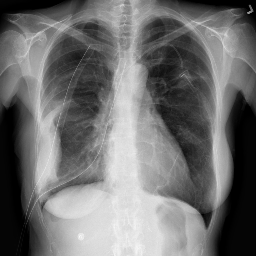

In [5]:
### Checking the sample image
from google.colab.patches import cv2_imshow
cv2_imshow(trainData[1])

In [0]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Creating the masks and X_train preprocessed data

In [7]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

X_train = np.zeros((int(trainData.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(trainData.shape[0]):
    img = trainData[index]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    img = np.stack((img,)*3, axis=-1)
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))


In [0]:
### Creating the masks array
masks = np.zeros((int(trainData.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
for i in range(0,len(trainDataBounding)):
  for bbDims in range(0,len(trainDataBounding[i])):
    try:
      x1 = (int(trainDataBounding[i][bbDims][1]))
      y1 = (int(trainDataBounding[i][bbDims][2]))
      x2 = ((int(trainDataBounding[i][bbDims][1]) + int(trainDataBounding[i][bbDims][3])))
      y2 = ((int(trainDataBounding[i][bbDims][2]) + int(trainDataBounding[i][bbDims][5])))
      masks[i][y1:(y1+y2),x1:(x1+x2)] = 1
    except:
      pass

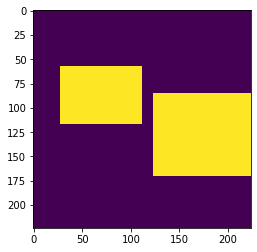

In [9]:
import matplotlib.pyplot as plt
plt.imshow(masks[7])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


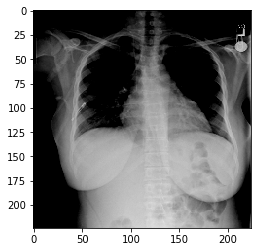

In [10]:
plt.imshow(X_train[7])

In [11]:
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet import MobileNet

model = MobileNet(input_shape= (IMAGE_HEIGHT, IMAGE_WIDTH, 3),include_top = False,alpha = 1,weights = 'imagenet')
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
17227776/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model


def create_model(trainable=True):
    model = MobileNet(input_shape= (IMAGE_HEIGHT, IMAGE_WIDTH, 3),include_top = False,alpha = 1,weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = trainable
    # getting the layers from mobilenet network
    conv_pw_13_relu = model.get_layer("conv_pw_13_relu").output
    conv_pw_11_relu = model.get_layer("conv_pw_11_relu").output
    conv_pw_10_relu = model.get_layer("conv_pw_10_relu").output
    conv_pw_9_relu = model.get_layer("conv_pw_9_relu").output
    conv_pw_8_relu = model.get_layer("conv_pw_8_relu").output
    conv_pw_7_relu = model.get_layer("conv_pw_7_relu").output
    conv_pw_6_relu = model.get_layer("conv_pw_6_relu").output
    conv_pw_5_relu = model.get_layer("conv_pw_5_relu").output
    conv_pw_4_relu = model.get_layer("conv_pw_4_relu").output
    conv_pw_3_relu = model.get_layer("conv_pw_3_relu").output
    conv_pw_2_relu = model.get_layer("conv_pw_2_relu").output
    conv_pw_1_relu = model.get_layer("conv_pw_1_relu").output
    input_1 = model.layers[0].output

    
    # Adding Unet layers
    # Each set will have 1 upsampling, then concat with the mobilenet layers having same shape
    # followed by 2 conved layers with extra parameters

    up2 = UpSampling2D()(conv_pw_13_relu)
    concat1 = Concatenate()([up2, conv_pw_11_relu])
    new_conv15 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(concat1)
    new_conv15 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(new_conv15)

    up3 = UpSampling2D()(concat1)
    concat2 = Concatenate()([up3, conv_pw_5_relu])
    new_conv16 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(concat2)
    new_conv16 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(new_conv16)

    up4 = UpSampling2D()(concat2)
    concat3 = Concatenate()([up4, conv_pw_3_relu])
    new_conv17 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(concat3)
    new_conv17 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(new_conv17)

    up5 = UpSampling2D()(concat3)
    concat4 = Concatenate()([up5, conv_pw_1_relu])
    new_conv17 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(concat4)
    new_conv17 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(new_conv17)

    up6 = UpSampling2D()(concat4)
    concat5 = Concatenate()([up6, input_1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(concat5)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)

### Call the create_model function

In [13]:
# Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
model = create_model(trainable=False)

# Print summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
______________________________________________________________________________________________

DICE Coefficient

In [0]:
import tensorflow as tf
def dice_coefficient(y_true, y_pred):
    #### Add your code here ####
    num = 2 * tf.reduce_sum(y_true * y_pred)
    den = tf.reduce_sum(y_true + y_pred)

    out = num / (den + tf.keras.backend.epsilon())
    return out

### Define loss

In [0]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [0]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

### Define checkpoint and earlystopping

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [18]:
model.fit(X_train,masks,epochs = 10,batch_size=10,callbacks=[checkpoint,reduce_lr,stop])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60 samples
Epoch 1/10
50/60 [========================>.....] - ETA: 1s - loss: 6.1402 - dice_coefficient: 0.0414
Epoch 00001: loss improved from inf to 5.80555, saving model to model-5.81.h5
60/60 [==============================] - 13s 219ms/sample - loss: 5.8055 - dice_coefficient: 0.0385
Epoch 2/10
50/60 [========================>.....] - ETA: 0s - loss: 6.0252 - dice_coefficient: 0.0464
Epoch 00002: loss improved from 5.80555 to 5.63506, saving model to model-5.64.h5
60/60 [==============================] - 1s 22ms/sample - loss: 5.6351 - dice_coefficient: 0.0445
Epoch 3/10
50/60 [========================>.....] - ETA: 0s - loss: 8.9738 - dice_coefficient: 0.0305
Epoch 00003: loss did not improve from 5.63506
60/60 [==============================] - 1s 19ms/sample - loss: 7.9444 - dice_coefficient: 0.0391
Epoch 4/10
50/60 [========================>.....] - ETA: 0s - loss: 6.0624 - 

In [19]:
### Sample image prediction
unscaled = X_train[7]
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))

### Preprocessing the image input
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))
### Prediction
predMask = model.predict(x=np.array([feat_scaled]))[0]
predMask

array([[1.45316124e-04, 1.45345926e-04, 1.29759312e-04, ...,
        2.35140324e-05, 2.65240669e-05, 2.65240669e-05],
       [1.45345926e-04, 1.45345926e-04, 1.29759312e-04, ...,
        2.36034393e-05, 2.65538692e-05, 2.65538692e-05],
       [1.63108110e-04, 1.63227320e-04, 2.97755003e-04, ...,
        5.48362732e-05, 5.98132610e-05, 5.98132610e-05],
       ...,
       [1.35600567e-05, 1.35898590e-05, 2.62260437e-05, ...,
        8.31484795e-06, 7.95722008e-06, 7.95722008e-06],
       [1.29640102e-05, 1.30236149e-05, 1.40070915e-05, ...,
        4.32133675e-06, 4.94718552e-06, 4.88758087e-06],
       [1.29938126e-05, 1.29640102e-05, 1.39772892e-05, ...,
        4.35113907e-06, 4.94718552e-06, 4.94718552e-06]], dtype=float32)

In [0]:
THRESHOLD = 0.08
EPSILON = 0.02

In [21]:
#### Add your code here ####
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

region = model.predict(x=np.array([feat_scaled]))[0]

output = np.zeros(unscaled.shape[:2], dtype=np.uint8)
for i in range(region.shape[1]):
    for j in range(region.shape[0]):
        if region[i][j] > THRESHOLD:
            x = int(CELL_WIDTH * j * unscaled.shape[1] / IMAGE_WIDTH)
            y = int(CELL_HEIGHT * i * unscaled.shape[0] / IMAGE_HEIGHT)
            x2 = int(CELL_WIDTH * (j + 1) * unscaled.shape[1] / IMAGE_WIDTH)
            y2 = int(CELL_HEIGHT * (i + 1) * unscaled.shape[0] / IMAGE_HEIGHT)
            #cv2.rectangle(unscaled, (x, y), (x2, y2), (0, 255, 0), 1)

            output[y:y2,x:x2] = 1

_, contours, _ = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contours:
    approx = cv2.approxPolyDP(cnt, EPSILON * cv2.arcLength(cnt, True), True)
    x, y, w, h = cv2.boundingRect(approx)
    cv2.rectangle(unscaled, (x, y), (x + w, y + h), (0, 255, 0), 1)

pyplot.imshow(unscaled)
cv2.waitKey(0)
cv2.destroyAllWindows()

NameError: ignored